In [1]:
from utils.ML1.utils import *
from utils import plotcfg
import graphviz
graphviz.set_jupyter_format('png');
from tqdm.notebook import tqdm

# Machine Learning based approach for a single joint
As seen in the last chapter(3.1), there are nonlinearities in the residuals, potentially arising from dynamic coupling and inaccuracies in modelling. These challenges cannot be fully addressed through analytical methods alone and necessitate a more statistical approach. Recent studies[] have demonstrated the effectiveness of machine learning (ML) in learning these residuals or modeling complex physical phenomena. Additionally, ML methods have the potential to learn the dynamic coupling characteristics[] when multiple joints are moving simultaneously, which is crucial for accurate torque estimation in complex robotic systems.

In this chapter, the approach is to utilize torque information from both encoders and motor currents, along with other relevant inputs such as joint velocity and torque feedforward to train four different model architectures. Since the ML model requires a target value for learning, and given the potential inaccuracies in encoder and current values, a force/torque sensor (FTS) was attached to the TCP, providing six output measurements (Fx, Fy, Fz, Tx, Ty, Tz). These TCP wrench measurements can be projected into the joint space using appropriate equations, thereby offering accurate external torque estimations. While FTS sensors have known issues, such as temperature drift[cite], this study assumes the external joint torque derived from the FTS readings to be accurate. In the end the results from four different models are compared and the performace of the best one is evalutaed against the baseline method. Similar to previous chapters, this analysis focuses on a single joint (Joint-3) for simplicity and to establish a baseline comparison before extending the modeling to all the joints.

## Data Collection
The robot was mounted vertically, with its base securely attached to a horizontal plane as shown in Figure 3.1. Joint-3 was rotated at a constant speed, sweeping from -150° to 150°. Additionally, external loads were mounted between measurements, with weights randomly selected from 0 kg, 1.225 kg, 2.225 kg, 3.225 kg, 5.225 kg, 7.225 kg, and 9.225 kg. For each load condition, 20 different joint velocities were drawn from a uniform distribution ranging between 0.01 rad/s and 1.15 rad/s. Each measurement involved a single to-and-fro motion.

During data collection, FTS readings (in TCP coordinate frame), joint velocity, joint angle, torque feedforward, motor torque, load-side encoder counts, and motor-side encoder counts were recorded. These measurements were taken at a sampling frequency of 500 Hz, equating to a sampling time of 2 millisecond. This high-resolution data acquisition was essential for capturing detailed and accurate information. Maintaining a 2 millisecond sampling time was crucial to meet real-time processing requirements [cite]. 

One of the measurements is kept aside for validation and is hence not used in training.



In [2]:
#run this cell to download the data
from utils.download_utils import download_and_extract_zip

data = download_and_extract_zip("ML1")

downloading data:   0%|          | 0/41794 [00:00<?, ?KB/s]

Folder downloaded and extracted successfully!


## Target Selection

The FTS sensor provides 6 readings namely $F_x, F_y, F_z, \tau_x, \tau_y,\tau_z$, since only Joint-3 is under study and is actuated, not all components of the wrench can be estimated from Joint-3. The relation between Wrench (${}^{TCP}W_{ext}$) and joint torque ($\tau_3$) is given by
$$
\tau_3 = {}^{TCP}J_3^T.{}^{TCP}W_{ext},
$$
a close examination of the Jacobain ${}^{TCP}J_3^T$ reveals that components of $W_{ext}$ which produce a torque in Joint-3 are $F_x, F_z$ and $\tau_y$. The derivation is provided in [Appendix](./Appendix.ipynb).

## Inputs and Data Preprocessing
The inputs used for analytical methods and motor-current-based approach are used here, namely joint velocity, motor current, torque feedforward, motor side and load side encoder measurements. These provide the necessary information for the model to estimate external joint torques. Joint angles, although an important component for gravity based torque was not included because this information is already present in the load side encoder measurements. In addition to this, use of encoder difference [refernce eqn] has also showed improvement in the results. 

Each of the seven input and 3 targets was min-max scaled using equation 7, to lie in the range of -1 to 1 which has been proven to benifit the model training[]. This range is usually prefered when the activation function of the model is $tanh$.

$$
Y' = \frac{(Y - Y_{\text{min}})}{(Y_{\text{max}} - Y_{\text{min}})} \times 2 - 1
$$

Where:
* $Y'$ is the scaled value.
* $Y$ is the original value.
* $Y_{\text{min}}$ is the minimum value in the original data.
* $Y_{\text{max}}$ is the maximum value in the original data.

The max and min values are saved for later inference to rescale the predictions to their original scale.

## Model Architecture

For the model, there are 7 inputs and 3 outputs. The model must be sufficiently large to accurately capture the physical mapping from inputs to outputs without overfitting, yet compact enough to be deployed on a robot equipped with an Intel® Core™ i5-10210U Processor, 16GB of RAM, and no GPU. It should achieve inference times under 2 milliseconds to meet realtime performance requirements. Given that the model needs to learn nonlinearities, such as hysteresis, which depend on the previous states of the joint, a recurrent neural network (FCN) architecture is an ideal candidate. Hence, recurrent architectures like RNNs, GRUs, and LSTMs and a Fully connected network are trained and their results compared. One example model definition is provided in code cell below for reference, with other models defined in model_definitions.py in the appendix[]. The model below consists of stacked GRUs followed by a fully connected neural network. The Tanh activation function is chosen for its ability to achieve higher nonlinearity in a smaller network, even though ReLU, while simpler and computationally efficient, would require a larger network to achieve similar results. A visualization of the 4 model architectures chosen for study are shown in Figure 1.

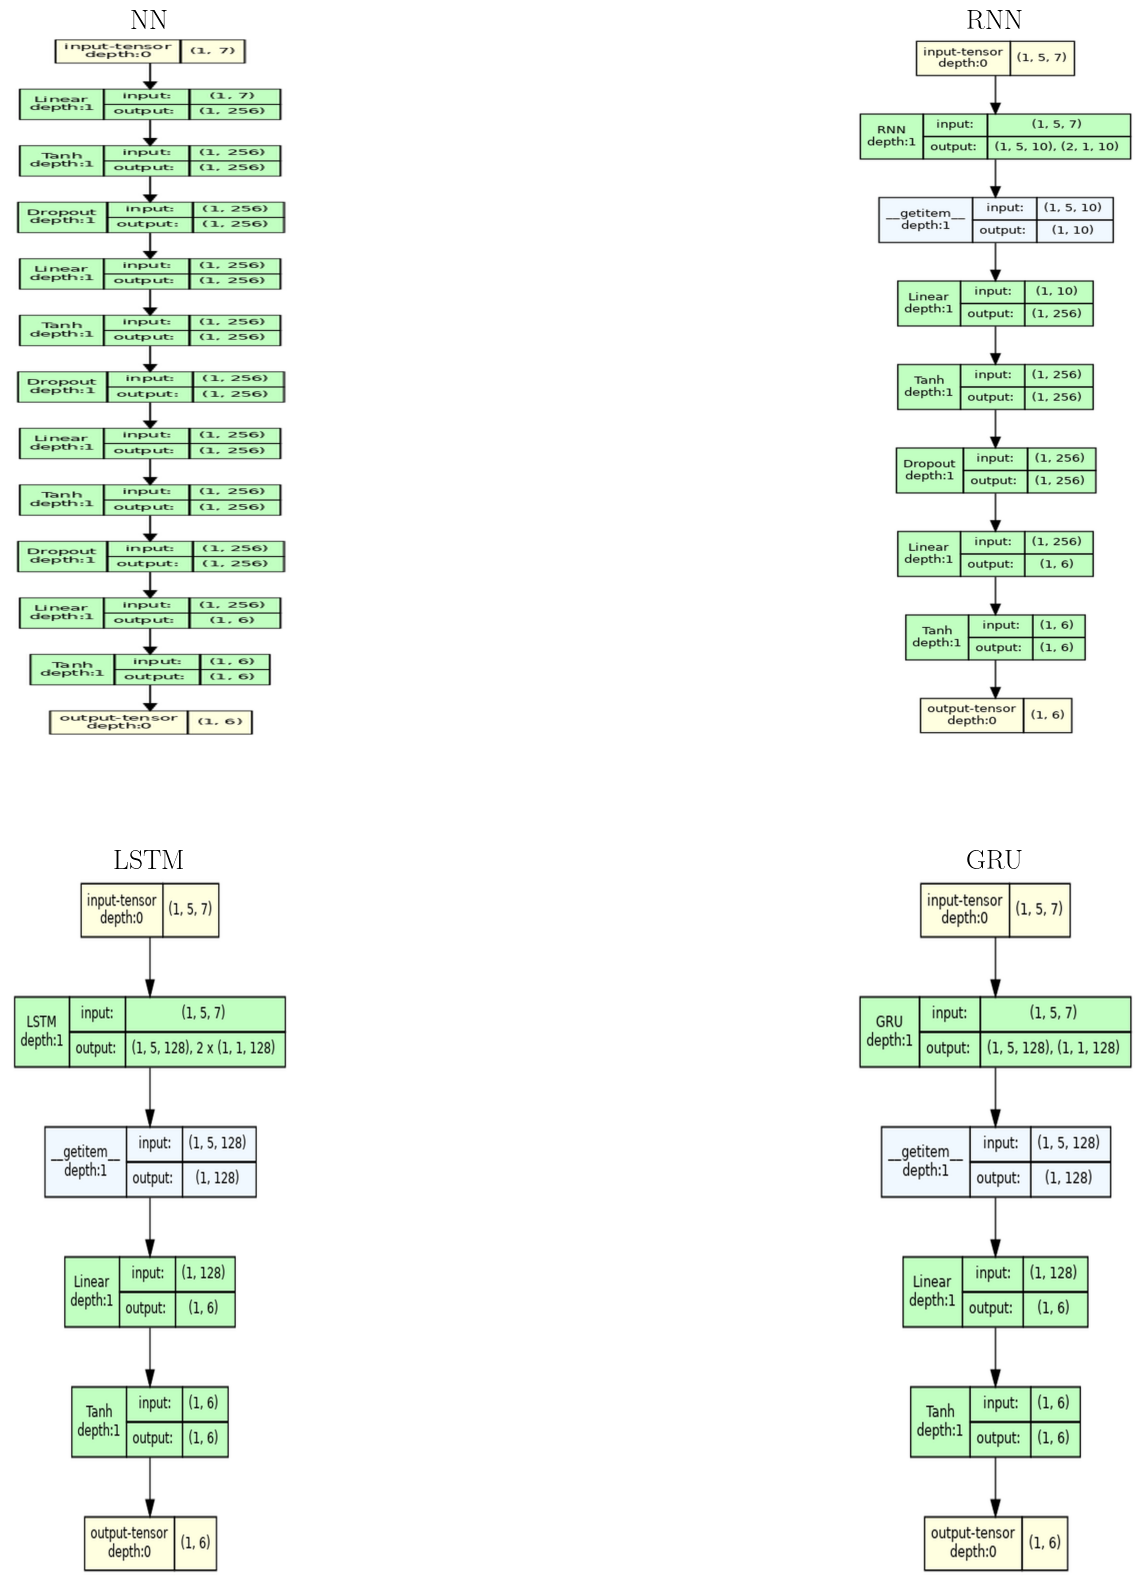

In [3]:
from utils.ML1.model_defenitions import NN, RNN, LSTM
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size,output_size)
        self.activation = nn.Tanh()
        
    def forward(self, x):
        out, _ = self.gru(x)  
        out = out[:, -1, :]
        out = self.activation(self.fc(out))
        return out
visualize_models()

## Training
The hyperparameters, including learning rate, number of epochs, batch size, hidden size, and number of layers, were optimized through grid search. However, to ensure a fair comparison among the three recurrent models, the sequence length was kept constant. The pre-processed data was segmented into sequences, shuffled, and then split into two distinct datasets: 75% was designated for training, while the remaining 25% for testing. This split allows the test dataset, which was not used during training, to serve as a validation set, enabling the detection of overfitting. Overfitting is identified when the validation loss begins to increase while the training loss continues to decrease.

In [4]:
#Hyperparameters
learning_rate = 0.0002
EPOCHS = 5
BATCH_SIZE = 2048
sequence_length = 5# length of each input sequence
hidden_size = 128 # number of hidden states of GRU
num_layers = 1 # number of GRU stacked one after the other
input_size = 7 # number of input features 
output_size = 6 # number of output (6 fts readings)

dataset = CustomDatasetFromCSV(csv_path = '/mnt/data/ML1/data.csv',sequence_length=sequence_length,mode="train")

train_length = int(0.75* len(dataset))
test_length = len(dataset)-train_length
train_dataset,test_dataset=torch.utils.data.random_split(dataset,(train_length,test_length))

The optimizer used is Adam[cite] which is a type of stochastic gradient descent technique. According to **Kingma et al., 2014**, Adam optimizer is "computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters".


The loss function used to train the machine learning model is the Mean Squared Error (MSE), which quantifies the difference between the predicted joint torques and the actual torques. The MSE is defined as:

\begin{equation}
MSE = \sum_{i=1}^{N}(y_i-{y_{pred}}_i)^2
\label{eq:5.1} \tag{5.1}
\end{equation}

where $y_i $ represents the actual wrench, $ {y_{pred}} $ is the model's predicted wrench based on the joint's position, and $n$ is the total number of samples. The training process involves iteratively updating the model's weights to minimize the loss. The process is conducted over multiple epochs, where each epoch consists of a complete pass through the training data. At the beginning of each epoch, the training data is loaded in batches. For each batch, the following steps are performed:

* Forward Propagation: The input sequence $X$ is passed through the model to generate the predicted output $y_{\text{pred}}$. The loss is then computed using equation 3.1.

* Backpropagation: The gradients of the loss with respect to the model's weights are calculated through backpropagation. 

* Optimization: The optimizer, Adam, is used to adjust the model's weights based on the computed gradients. This step aims to minimize the loss function, thereby improving the model's predictions over time.

The process is repeated for the set number of epochs, with each epoch contributing to the gradual reduction of the loss. The code used for training GRU model is provided for reference, however  pretrained models will be used in the 

In [5]:
import os

file_path = "utils/ML1/models/GRU_model.pt"
if os.path.exists(file_path):
    print("using pre-trained model")
    nn_model = torch.jit.load('utils/ML1/models/NN_model.pt', map_location=torch.device('cpu'))
    rnn_model = torch.jit.load('utils/ML1/models/RNN_model.pt', map_location=torch.device('cpu'))
    gru_model = torch.jit.load('utils/ML1/models/GRU_model.pt', map_location=torch.device('cpu'))
    lstm_model = torch.jit.load('utils/ML1/models/LSTM_model.pt', map_location=torch.device('cpu'))
else:
    model = GRU(input_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
    # Train the model
    n_total_steps = len(train_dataloader)
    for epoch in range(EPOCHS):
        for i, (X, y) in enumerate(progress_bar): 
            #Forward propagation
            y_pred = model(X)
            loss = criterion(y_pred, y)
            # Backpropagation and optimize
            model.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

using pre-trained model


## Resuts

An inference is done on all the models and the predictions are rescaled to their original scale. The figure below shows the prediction of all four trained models.

  0%|          | 0/1827 [00:00<?, ?it/s]

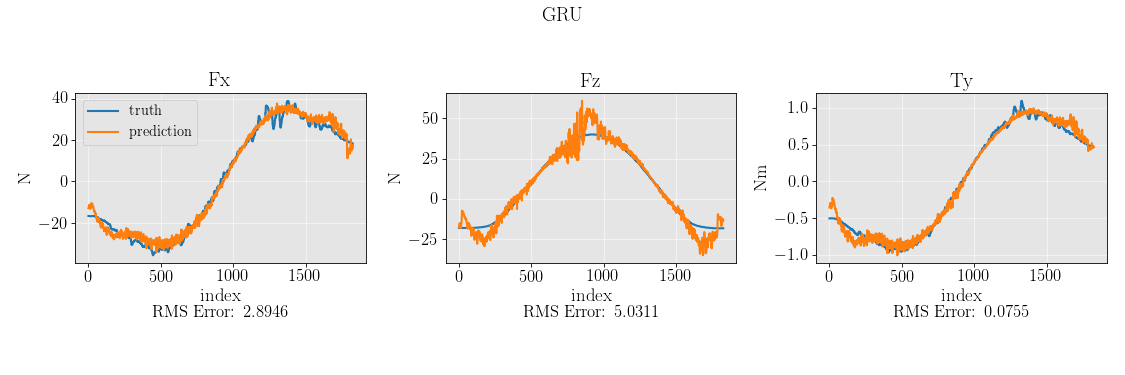

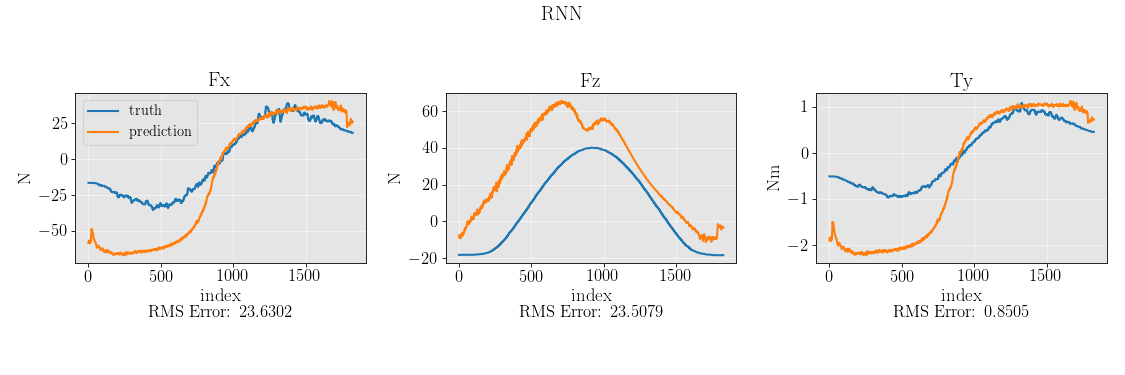

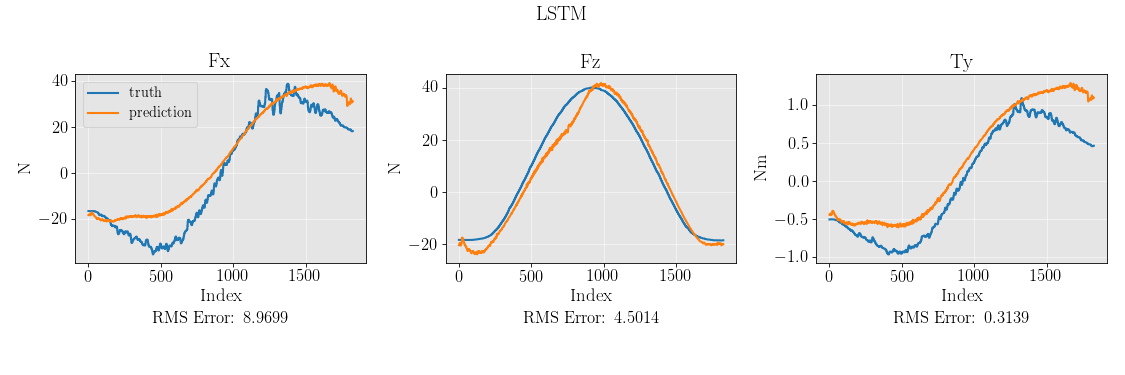

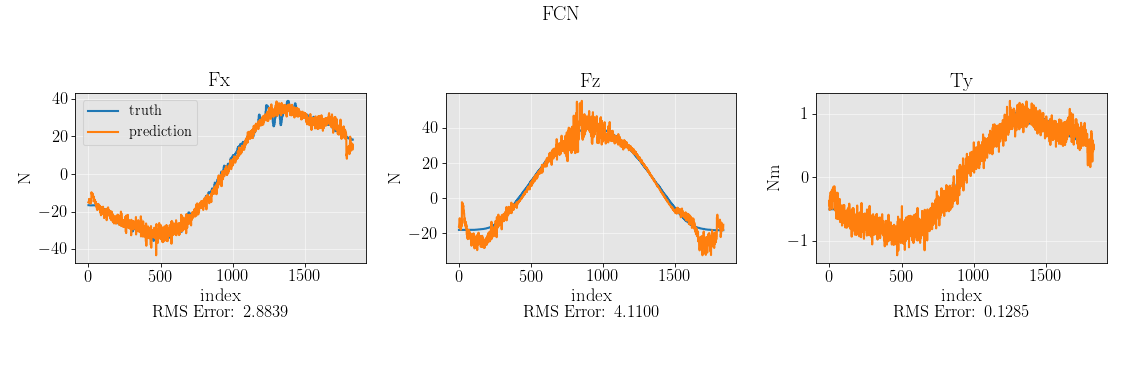

In [6]:
# To denormalize the predictions
y_max = torch.load('utils/ML1/fts_GRU/models/y_max.pt', map_location=torch.device('cpu'))
y_min = torch.load('utils/ML1/fts_GRU/models/y_min.pt', map_location=torch.device('cpu'))

dataset = CustomDatasetFromCSV(csv_path='utils/ML1/fts_GRU/data/validate.csv', sequence_length=sequence_length, device="cpu", mode="test")
test_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

model = torch.jit.load('utils/ML1/fts_GRU/models/model.pt', map_location=torch.device('cpu'))
model.eval()

pred_list = []
with torch.no_grad():
    for i, (X, y) in enumerate(tqdm(test_dataloader)):
        pred = model(X)
        pred = (pred + 1) / 2 * (y_max - y_min) + y_min
        pred_list.append(pred)

# Denormalize the data
y_truth = ((test_dataloader.dataset.y + 1) / 2 * (y_max - y_min) + y_min).cpu().numpy()
pred_list = torch.cat(pred_list).cpu().numpy()

show_test_graphs()

The predictions of the ML models are plotted in orange and the reference from the FTS which is assumed to be the truth here, is plotted in blue. The RMS error of the predictions are given in the table below. Out of the four models, it can be seen from the plots and also Table below that FCN and GRU architecture performs good. Since the prediction involvles accounting for hysteysis which is dependent on the history of the trajectory, a recurrent architecture like GRU is the best choice. The predictions of the FCN network are noisy, this could have been due to overfitting becuase the network was too simple and since the training paramters were same for all models, FCN could have learned the noise in the training data. While these results may vary with further optimization of each model and corresponding training parameters, the current findings highlight the effectiveness of GRU in this application, making it a strong candidate for modeling across all joints. A detailed hyperparameter optimization will be conducted in the next chapter.

| **Model** | **Fx RMS Error** | **Fz RMS Error** | **Ty RMS Error** |
|-----------|------------------|------------------|------------------|
| GRU      | **2.8946**           | **5.0311**           | **0.0755**           |
| RNN       | 23.6302          | 23.5079          | 0.8505           |
| LSTM      | 8.9699           | 4.5014           | 0.3139           |
| FCN       | **2.8823**           | **4.1089**           | **0.1265**           |


## Comparison with baseline approaches

A comparison is done to evaluate how well the GRU model performs in comparison to motor-current based method, which can be seen in figure X. The  predictions of the ML model are converted to joint torque using equation X. 

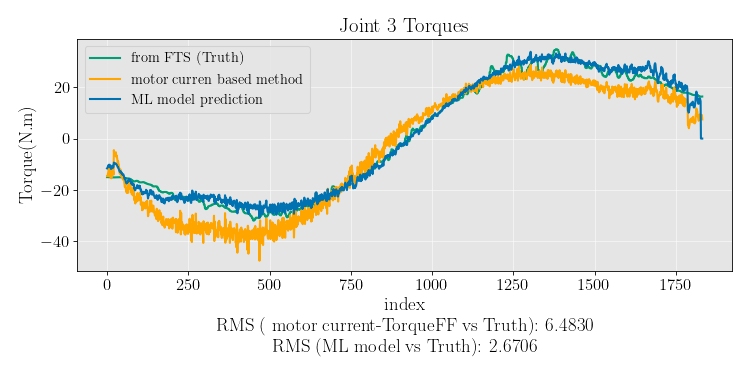

In the Figure, the motor current based estimation is plotted in orange, the reference is plotted in green and the prediction of the ML model is plotted in blue. From the plot it is clear that the ML model predictions closely match the projected FTS measurements.
The RMS error between motor current based method and the FTS readings are 6.4830Nm and the RMS error between ML model and FTS readings is 2.6706Nm which shows a significant improvement of **58.8%**. 

However the same limitation seen in section 4.6 applies here as well, since this is also a single joint model. This motivates the next chapter, where this GRU architecture is trained on inputs from all joints. This is hypothesised to provide enough information to capture the dynamic coupling which is the reason for the limitation.           . 